# 데이터 불러오기

In [1]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime

pd.set_option('display.max_columns', None)  # 모든 컬럼 다 보이게 설정

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import shapiro

# 지리 라이브러리
from geopy.distance import geodesic

# 전처리용
from itertools import combinations

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 윈도우용 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 말굿 고딕 (Windows 기본 한글 폰트)
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 머신러닝 - 전처리, 모델, 평가
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 머신러닝 알고리즘 (필요에 따라 선택적으로 추가)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRegressor

# 텍스트 처리
from rapidfuzz import process, fuzz

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# # # 딥러닝 (선택사항)
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# 모델 해석
import shap



In [2]:
subway_test_before  = pd.read_excel('./data/test_subway.xlsx')
air_test_before     = pd.read_csv('./data/test_air.csv', encoding='cp949')
weather_test_before = pd.read_excel('./data/test_weather.xlsx')
subway_train_before = pd.read_csv('./data/train_subway.csv', encoding='cp949')
air_train_before    = pd.read_csv('./data/train_air.csv', encoding='cp949')
weather_train_before = pd.read_csv('./data/train_weather.csv', encoding='cp949')

In [3]:
air_train_before['공기질'].unique()

array([ 0.,  1., nan])

In [16]:
# 전처리 함수 정의
def preprocess_air(df):
    df['일시'] = pd.to_datetime(df['일시'], format='%Y-%m-%d %H')
    df['역명_호선'] = df['역명'] + "_" + df['호선'].astype(str)
    return df[['일시', '역명_호선', '공기질']]

def preprocess_subway(df):
    df['수송일자'] = pd.to_datetime(df['수송일자'])
    df['역명_호선'] = df['역명'] + "_" + df['호선'].str.extract(r'(\d+)호선')[0]
    time_cols = [col for col in df.columns if '시' in col or '시간대' in col]
    df_melted = df.melt(id_vars=['수송일자', '역명_호선'], value_vars=time_cols, var_name='시간', value_name='승하차수')
    df_melted['시간'] = df_melted['시간'].str.extract(r'(\d+)')[0].astype(float).fillna(0).astype(int)
    df_melted['일시'] = df_melted['수송일자'] + pd.to_timedelta(df_melted['시간'], unit='h')
    df_grouped = df_melted.groupby(['일시', '역명_호선'])['승하차수'].sum().reset_index()
    return df_grouped

def preprocess_subway(df):
    df['수송일자'] = pd.to_datetime(df['수송일자'])
    df['역명_호선'] = df['역명'] + "_" + df['호선'].str.extract(r'(\d+)호선')[0]

    time_cols = [col for col in df.columns if '시' in col or '시간대' in col]
    df_melted = df.melt(
        id_vars=['수송일자', '역명_호선'],
        value_vars=time_cols,
        var_name='시간',
        value_name='승하차수'
    )

    # 시간 문자열 처리
    df_melted['시간_str'] = df_melted['시간']  # 원본 보존
    df_melted['시간'] = df_melted['시간'].str.extract(r'(\d+)')[0].astype(float).fillna(0).astype(int)

    # 06시이전은 5시로, 24시이후는 24시로 고정
    df_melted.loc[df_melted['시간_str'].str.contains('06시이전'), '시간'] = 5
    df_melted.loc[df_melted['시간_str'].str.contains('24시이후'), '시간'] = 0

    # 일시 계산: 시간 기준으로 일단 더하고
    df_melted['일시'] = df_melted['수송일자'] + pd.to_timedelta(df_melted['시간'], unit='h')

    # 24시이후는 +1일 조정 (이미 시간은 0시로 설정했음)
    is_after_midnight = df_melted['시간_str'].str.contains('24시이후')
    df_melted.loc[is_after_midnight, '일시'] += pd.Timedelta(days=1)

    # 최종 집계
    df_grouped = df_melted.groupby(['일시', '역명_호선'])['승하차수'].sum().reset_index()
    return df_grouped

def preprocess_weather(df):
    df['일시'] = pd.to_datetime(df['일시'], format='%Y-%m-%d %H:%M')
    df = df.fillna(0)
    return df

In [17]:
# 전처리 적용
air_train = preprocess_air(air_train_before)
air_test = preprocess_air(air_test_before)
subway_train = preprocess_subway(subway_train_before)
subway_test = preprocess_subway(subway_test_before)
weather_train = preprocess_weather(weather_train_before)
weather_test = preprocess_weather(weather_test_before)

In [18]:
air_train['공기질'].unique(), air_train.shape

(array([ 0.,  1., nan]), (87600, 3))

In [19]:
# 통합 함수
def merge_data(air, subway, weather):
    # 일시 컬럼 타입 통일
    air['일시'] = pd.to_datetime(air['일시'])
    subway['일시'] = pd.to_datetime(subway['일시'])
    weather['일시'] = pd.to_datetime(weather['일시'])

    # 병합 수행
    df = air.merge(subway, on=['일시', '역명_호선'], how='left')
    df = df.merge(weather, on='일시', how='left')

    df['승하차수'] = df['승하차수'].fillna(0)
    # df = df.dropna()

    return df

train_df = merge_data(air_train, subway_train, weather_train)
test_df = merge_data(air_test, subway_test, weather_test)

In [ ]:
train_df.to_csv('./data2/train.csv', encoding='cp949')

In [8]:
train_df['공기질'].unique(), train_df.shape

(array([ 0.,  1., nan]), (87600, 20))

In [68]:
# 모델 학습용 데이터 준비
def prepare_features(df):
    df['hour'] = df['일시'].dt.hour
    df['weekday'] = df['일시'].dt.weekday
    categorical = ['역명_호선', 'hour', 'weekday']
    df = pd.get_dummies(df, columns=categorical, drop_first=True)
    X = df.drop(columns=['일시', '공기질'])
    y = df['공기질']
    return X, y

X_train, y_train = prepare_features(train_df)
X_test, y_test = prepare_features(test_df)

In [69]:
# 모델 학습
model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 평가 지표 계산
accuracy = (y_pred == y_test).mean()
misclassification_rate = 1 - accuracy
ks_stat = max(abs(roc_curve(y_test, y_proba)[1] - roc_curve(y_test, y_proba)[2]))
auroc = roc_auc_score(y_test, y_proba)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]

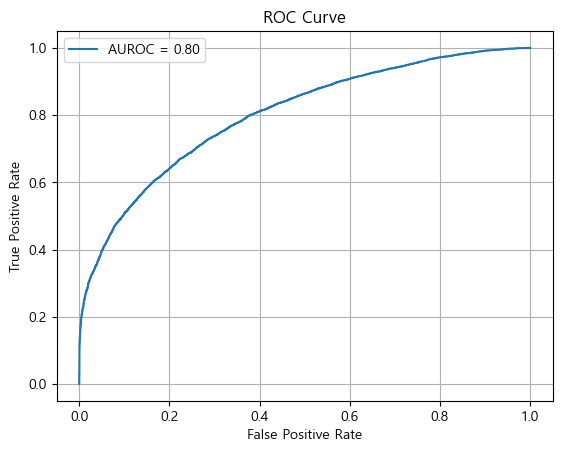

In [32]:
# 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
print(misclassification_rate, ks_stat, auroc, len(y_test))

0.267590618336887 inf 0.8010483437375645 21574


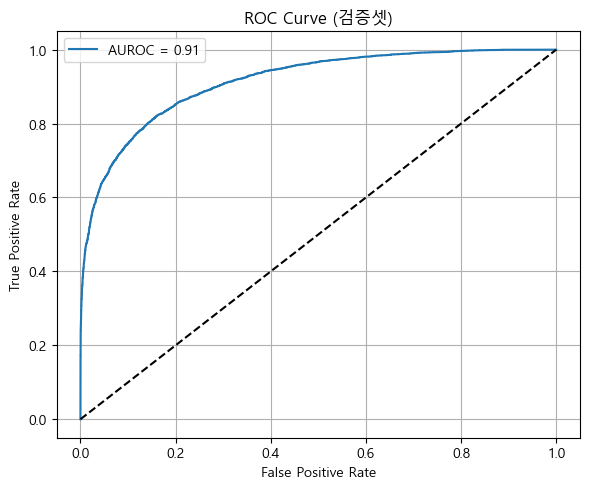

(0.8320806714267819,
 0.16791932857321812,
 0.6606935253590862,
 0.9137179666713345,
 15966)

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Step 1: 특성 생성
train_df['hour'] = train_df['일시'].dt.hour
train_df['weekday'] = train_df['일시'].dt.weekday
X = train_df.drop(columns=['일시', '공기질'])
X = pd.get_dummies(X, columns=['역명_호선', 'hour', 'weekday'], drop_first=True)
y = train_df['공기질'].astype(int)

# Step 2: 학습/검증 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: XGBoost 분류 모델 학습
model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Step 4: 예측 및 성능 평가
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]

# 정확도 및 오분류율
accuracy = (y_pred == y_val).mean()
misclassification_rate = 1 - accuracy

# KS 통계량
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks_stat = max(tpr - fpr)

# AUROC
auroc = roc_auc_score(y_val, y_proba)

# 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (검증셋)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 출력
(accuracy, misclassification_rate, ks_stat, auroc, len(y_val))


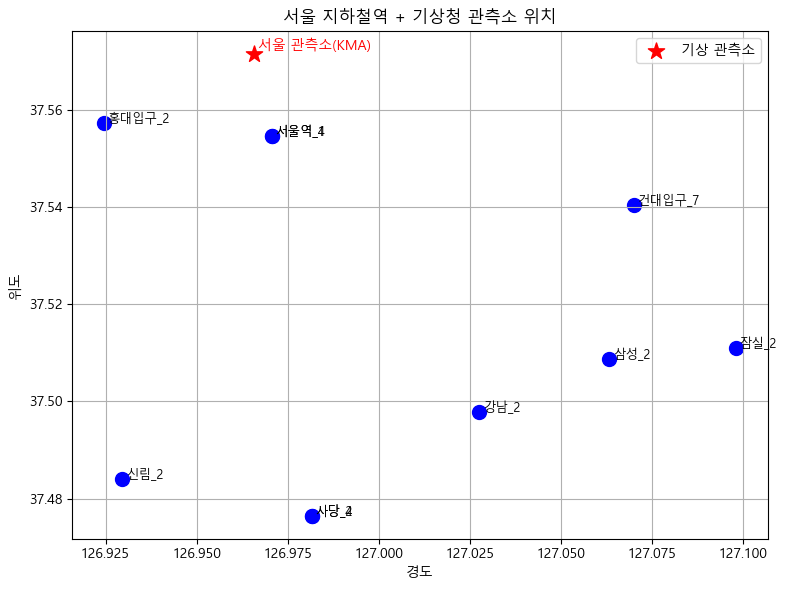

In [36]:
# train_weather.csv의 일시/기온 등을 기준으로 관측소 위치 정보를 추론할 수는 없으므로,
# 서울 지역 기상 데이터의 일반적 관측소 위치(서울 종로구 송월동 기상청)를 기준으로 지도에 표시합니다.

# 위경도 좌표: 서울 종로구 송월동 (기상청 본청)
kma_lat, kma_lon = 37.5714, 126.9658

# 기존 역 위경도 정보 다시 정의
station_coords = {
    '강남_2': (37.4979, 127.0276),
    '건대입구_7': (37.5405, 127.0701),
    '사당_2': (37.4765, 126.9816),
    '사당_4': (37.4765, 126.9816),
    '삼성_2': (37.5088, 127.0632),
    '서울역_1': (37.5547, 126.9707),
    '서울역_4': (37.5547, 126.9707),
    '신림_2': (37.4840, 126.9296),
    '잠실_2': (37.5110, 127.0980),
    '홍대입구_2': (37.5572, 126.9245)
}
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 역 위치
for name, (lat, lon) in station_coords.items():
    plt.scatter(lon, lat, c='blue', s=100)
    plt.text(lon + 0.001, lat, name, fontsize=9)

# 기상 관측소 위치 추가
plt.scatter(kma_lon, kma_lat, c='red', s=150, marker='*', label='기상 관측소')
plt.text(kma_lon + 0.001, kma_lat + 0.001, '서울 관측소(KMA)', fontsize=10, color='red')

plt.title("서울 지하철역 + 기상청 관측소 위치")
plt.xlabel("경도")
plt.ylabel("위도")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import folium

# 지도 생성: 서울 중심부 기준

map_seoul = folium.Map(
    location=[37.55, 126.98],
    zoom_start=15
)
# 기상 관측소 마커 추가
folium.Marker(
    [kma_lat, kma_lon],
    popup="서울 관측소(KMA)",
    icon=folium.Icon(color='red', icon='cloud')
).add_to(map_seoul)

# 역 좌표 마커 추가
for name, (lat, lon) in station_coords.items():
    folium.Marker(
        [lat, lon],
        popup=name,
        icon=folium.Icon(color='blue', icon='train', prefix='fa')
    ).add_to(map_seoul)

# 지도 출력
map_seoul

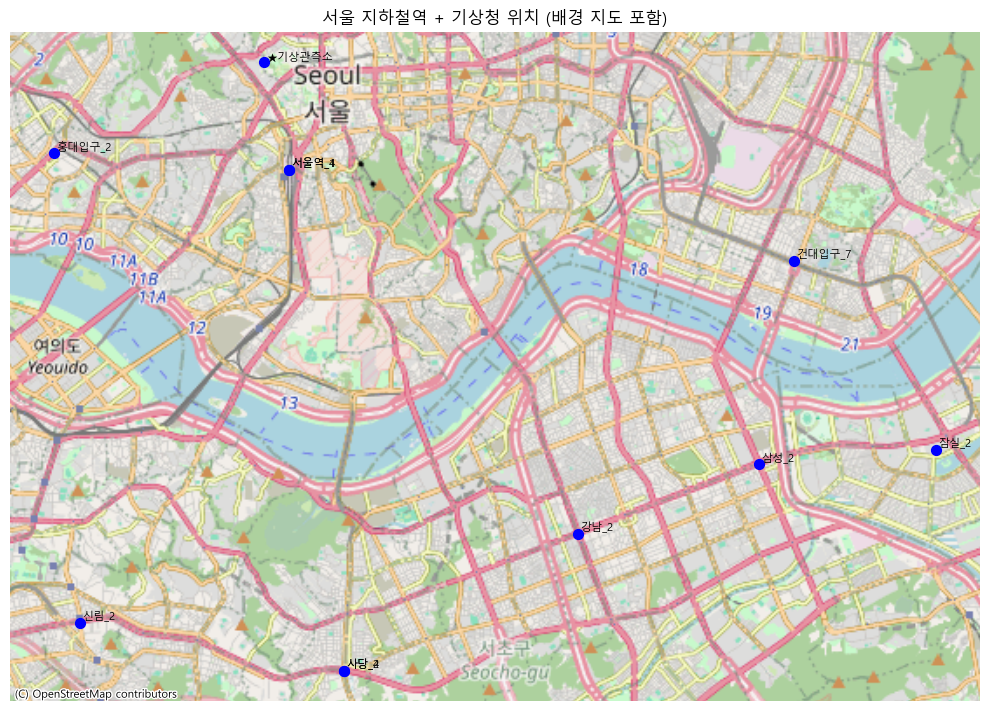

In [44]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1. 지하철 역 + 기상청 위치 통합
locations = {
    '★기상관측소': (37.5714, 126.9658),
    '강남_2': (37.4979, 127.0276),
    '건대입구_7': (37.5405, 127.0701),
    '사당_2': (37.4765, 126.9816),
    '사당_4': (37.4765, 126.9816),
    '삼성_2': (37.5088, 127.0632),
    '서울역_1': (37.5547, 126.9707),
    '서울역_4': (37.5547, 126.9707),
    '신림_2': (37.4840, 126.9296),
    '잠실_2': (37.5110, 127.0980),
    '홍대입구_2': (37.5572, 126.9245)
}

df = pd.DataFrame(locations).T.reset_index()
df.columns = ['name', 'lat', 'lon']

# 2. GeoDataFrame으로 변환 (좌표계: WGS84 → EPSG:4326)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['lon'], df['lat'])],
    crs="EPSG:4326"
).to_crs(epsg=3857)  # contextily는 EPSG:3857로 필요

# 3. 시각화
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, color='blue', markersize=50)

for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['name']):
    ax.text(x + 50, y + 50, label, fontsize=8)

# 지도 타일 배경 추가
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.DE)

ax.set_axis_off()
plt.title("서울 지하철역 + 기상청 위치 (배경 지도 포함)", fontsize=12)
plt.tight_layout()
plt.show()


In [39]:
# air train preprocess
import pandas as pd

# 원본 데이터 불러오기
df = pd.read_csv("./data/train_air.csv", encoding='cp949')  # 또는 utf-8-sig

# datetime 처리
df["일시_dt"] = pd.to_datetime(df["일시"], format="%Y-%m-%d %H")
df["날짜"] = df["일시_dt"].dt.date.astype(str)
df["시간"] = df["일시_dt"].dt.strftime("%H:%M")
df["요일"] = df["일시_dt"].dt.day_name(locale='ko_KR')  # 요일 한글

# 분기 및 계절
df["분기"] = df["일시_dt"].dt.quarter
월 = df["일시_dt"].dt.month
df["계절"] = pd.cut(월,
    bins=[0, 2, 5, 8, 11, 12],
    labels=["겨울", "봄", "여름", "가을", "겨울"],  # 중복 허용
    include_lowest=True,
    right=True,
    ordered=False
).astype(str)

# 역명_호선
df["역명_호선"] = df["역명"] + "_" + df["호선"].astype(str)

# 저장
df.to_csv("./data/train_air_prep.csv", index=False, encoding='utf-8-sig')


In [5]:
df

,ID,호선,역명,일시,공기질,일시_dt,날짜,시간,요일,분기,계절,역명_호선
0,1,2,강남,2022-01-01 00,0.0,2022-01-01 00:00:00,2022-01-01,00:00,토요일,1,겨울,강남_2
1,2,2,강남,2022-01-01 01,1.0,2022-01-01 01:00:00,2022-01-01,01:00,토요일,1,겨울,강남_2
2,3,2,강남,2022-01-01 02,0.0,2022-01-01 02:00:00,2022-01-01,02:00,토요일,1,겨울,강남_2
3,4,2,강남,2022-01-01 03,0.0,2022-01-01 03:00:00,2022-01-01,03:00,토요일,1,겨울,강남_2
4,5,2,강남,2022-01-01 04,0.0,2022-01-01 04:00:00,2022-01-01,04:00,토요일,1,겨울,강남_2
...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,2,홍대입구,2022-12-31 19,1.0,2022-12-31 19:00:00,2022-12-31,19:00,토요일,4,겨울,홍대입구_2
87596,87597,2,홍대입구,2022-12-31 20,1.0,2022-12-31 20:00:00,2022-12-31,20:00,토요일,4,겨울,홍대입구_2
87597,87598,2,홍대입구,2022-12-31 21,1.0,2022-12-31 21:00:00,2022-12-31,21:00,토요일,4,겨울,홍대입구_2
87598,87599,2,홍대입구,2022-12-31 22,1.0,2022-12-31 22:00:00,2022-12-31,22:00,토요일,4,겨울,홍대입구_2


In [25]:
df

,name,lat,lon
0,강남_2,37.4979,127.0276
1,건대입구_7,37.5405,127.0701
2,사당_2,37.4765,126.9816
3,사당_4,37.4765,126.9816
4,삼성_2,37.5088,127.0632
5,서울역_1,37.5547,126.9707
6,서울역_4,37.5547,126.9707
7,신도림_1,37.5087,126.8914
8,신도림_2,37.5087,126.8914
9,홍대입구_2,37.5572,126.9245


In [4]:
train_df['공기질'].unique()

NameError: name 'train_df' is not defined

In [11]:
# air_train_before    .isna().sum(),\
# air_test_before     .isna().sum(),\
# subway_train_before .isna().sum(),\
# # subway_test_before  .isna().sum(),\
weather_train_before.isna().sum() - 8760,\
# weather_test_before .isna().sum()


(일시                  0
 기온(°C)              0
 강수량(mm)          7821
 풍속(m/s)             0
 습도(%)               0
 증기압(hPa)            0
 이슬점온도(°C)           0
 현지기압(hPa)           0
 해면기압(hPa)           0
 일조(hr)           3969
 일사(MJ/m2)        3969
 적설(cm)           8271
 지면온도(°C)            1
 5cm 지중온도(°C)        1
 10cm 지중온도(°C)       1
 20cm 지중온도(°C)       1
 30cm 지중온도(°C)       1
 dtype: int64,)